# EVE EDA
#### Milo @ Berkeley
#### Dec 2022

Run the `create_flare_list.py` script to create the `>C1_flares.csv` file containing all >C1 flares in the 2010/4/30 - 2010/4/30 time range. 

In [48]:
import pandas as pd
import astropy.units as u
import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as md

In [49]:
def flareclass_to_flux(goes_class_str):
    """copied from sunpy"""
    if not isinstance(goes_class_str, type('str')):
        raise TypeError("Input must be a string")

    GOES_CONVERSION_DICT = {'X': u.Quantity(1e-4, "W/m^2"),
                            'M': u.Quantity(1e-5, "W/m^2"),
                            'C': u.Quantity(1e-6, "W/m^2"),
                            'B': u.Quantity(1e-7, "W/m^2"),
                            'A': u.Quantity(1e-8, "W/m^2")}

    # invert the conversion dictionary
    # conversion_dict = {v: k for k, v in GOES_CONVERSION_DICT.items()}
    return float(goes_class_str.upper()[1:]) * GOES_CONVERSION_DICT[goes_class_str.upper()[0]]

In [54]:
# Read CSV file with Flare List >C1
All_flares = pd.read_csv('./C1_flares.csv')
# Convert all times into datetime objects
All_flares.event_starttime = pd.to_datetime(All_flares.event_starttime)
All_flares.event_peaktime = pd.to_datetime(All_flares.event_peaktime)
All_flares.event_endtime = pd.to_datetime(All_flares.event_endtime)
# Convert all GOES classes (str) into Power quantities (float * unit)
All_flares['fl_goescls_float'] = All_flares.fl_goescls.apply(flareclass_to_flux)

In [55]:
All_flares

,event_starttime,event_peaktime,event_endtime,fl_goescls,ar_noaanum,fl_goescls_float
0,2010-04-30 19:28:00,2010-04-30 19:34:00,2010-04-30 19:38:00,C2.2,11067,2.2e-06 W / m2
1,2010-05-01 01:34:00,2010-05-01 01:39:00,2010-05-01 01:43:00,C5.7,11067,5.7e-06 W / m2
2,2010-05-04 16:15:00,2010-05-04 16:29:00,2010-05-04 16:34:00,C3.6,11069,3.6e-06 W / m2
3,2010-05-05 07:09:00,2010-05-05 07:16:00,2010-05-05 07:20:00,C2.3,11069,2.2999999999999996e-06 W / m2
4,2010-05-05 11:37:00,2010-05-05 11:52:00,2010-05-05 11:58:00,C8.8,11069,8.8e-06 W / m2
...,...,...,...,...,...,...
10298,2022-10-28 22:15:00,2022-10-28 22:22:00,2022-10-28 22:26:00,C1.6,0,1.6e-06 W / m2
10299,2022-10-29 09:49:00,2022-10-29 09:56:00,2022-10-29 10:03:00,C1.9,0,1.8999999999999998e-06 W / m2
10300,2022-10-29 10:24:00,2022-10-29 10:32:00,2022-10-29 10:40:00,C1.1,0,1.1e-06 W / m2
10301,2022-10-29 18:58:00,2022-10-29 19:14:00,2022-10-29 19:37:00,C1.1,0,1.1e-06 W / m2


### Reading EVE Historical Data

In [15]:
def Load_Data(time_ref):
    # Path where all EVE data is stored
    path = './EVE_Data/lasp.colorado.edu/eve/data_access/eve_data/quicklook/L0CS/SpWx/'
    year = time_ref.year
    month = time_ref.strftime('%m')
    day = time_ref.strftime('%d')    
    # Read the Date of the observation from the first line after header
    EVE_date = pd.read_csv(f'{path}{year}/{year}{month}{day}'+\
                           '_EVE_L0CS_DIODES_1m.txt',
                           comment=';', sep= '\s+', nrows=1, dtype = str,
                           names=['year', 'nday', 'month', 'day'])
    # Read the Date of the observation from the first line after header
    EVE_date = pd.read_csv(f'{path}{year}/{year}{month}{day}'+\
                           '_EVE_L0CS_DIODES_1m.txt',
                           comment=';', sep= '\s+', nrows=1, dtype = str,
                           names=['year', 'nday', 'month', 'day'])
    # Column names
    cols = ['HHMM', 'XRS-B_proxy', 'XRS-A_proxy', 'SEM_proxy', '0.1-7_ESPquad', 
            '17.1_ESP', '25.7_ESP', '30.4_ESP', '36.6_ESP', 'dark_ESP', '121.6_MEGS-P', 
            'dark_MEGS-P', 'q0_ESP', 'q1_ESP', 'q2_ESP', 'q3_ESP', 'CM_Lat', 'CM_Lon',
            'x_cool_Proxy', 'oldXRSB_proxy']
    # Read all EVE data from the given day
    EVE_df = pd.read_csv(f'{path}{year}/{year}{month}{day}'+\
                          '_EVE_L0CS_DIODES_1m.txt',
                          sep= '\s+', names=cols, comment=';', parse_dates=['HHMM'],
                          date_parser=lambda x: pd.to_datetime(EVE_date.year[0]+\
                                                               EVE_date.month[0]+\
                                                               EVE_date.day[0]+\
                                                               x, 
                                                               format="%Y%m%d%H%M"))
    # Drop first row (already read as EVE_date)
    EVE_df.drop(index=EVE_df.index[0], axis=0, inplace=True)
    EVE_df.reset_index(drop=True, inplace=True)

    return EVE_df

def EVE_Data(time_ref):
    # DeltaT: How many minutes before and after the peaktime to get
    DeltaT = pd.Timedelta(minutes=40)
    EVE_df = Load_Data(time_ref)
    # Choose only times around the hour and minute given in time_ref of DeltaT width
    start_date = time_ref - DeltaT
    end_date = time_ref + DeltaT
    mask = (EVE_df.HHMM >= start_date) & (EVE_df.HHMM <= end_date)
    EVE_df = EVE_df.loc[mask]
    # If the flare happened at midnight, read the file after or before to complete time
    if (time_ref - time_ref.normalize() + DeltaT).days == 1:
        # if peaktime close to midnight from the left (~23h)
        EVE_df_dayafter = Load_Data(time_ref + DeltaT)
        EVE_df_dayafter = EVE_df_dayafter.loc[(EVE_df_dayafter.HHMM <= (time_ref + DeltaT))]
        EVE_df = pd.concat([EVE_df, EVE_df_dayafter]).reset_index(drop=True)
    elif (time_ref - time_ref.normalize() - DeltaT).days == -1:
        # if peaktime close to midnight from the right (~00h)
        EVE_df_daybefore = Load_Data(time_ref - DeltaT)
        EVE_df_daybefore = EVE_df_daybefore.loc[(EVE_df_daybefore.HHMM >= (time_ref - DeltaT))]
        EVE_df = pd.concat([EVE_df_daybefore, EVE_df]).reset_index(drop=True)
    else:
        EVE_df = EVE_df.reset_index(drop=True)
    
    return EVE_df

In [40]:
def MakePlot(event_ref):
    save_path = './Plots/'
    EVE_df = EVE_Data(event_ref.event_peaktime)
    colors = plt.rcParams["axes.prop_cycle"]()
    fig, ax = plt.subplots(len(EVE_df.keys()[1:]),1, figsize=(14,len(EVE_df.keys()[1:])), sharex=True)
    ax[0].set_title(event_ref.event_peaktime.strftime('SOL%Y%m%dT%X')+\
                    '_'+event_ref.fl_goescls,
                    fontsize=28)
    for y, ax in zip(EVE_df.keys()[1:], ax.flatten()):
        ax.axvline(x=event_ref.event_peaktime, color='grey',linestyle='--')
        ax.axvspan(event_ref.event_starttime, event_ref.event_endtime, alpha=0.2, color='grey')
        # Get the next color from the cycler
        c = next(colors)["color"]
        #logy = False
        logy = False if y in ['CM_Lat','CM_Lon'] else True
        EVE_df.plot(x='HHMM', y=y, ax=ax, color=c, drawstyle="steps", linewidth=2, logy=logy)

    # Hornaments
    xfmt = md.DateFormatter('%H:%M')
    ax.xaxis.set_major_formatter(xfmt)
    ax.set_xlim((EVE_df.HHMM[0],EVE_df.HHMM.tail(1)))
    ax.tick_params(axis='x', labelsize=16)
    ax.set_xlabel('Time [Hour:Minute]',fontsize=20)
    fig.subplots_adjust(wspace=0, hspace=0)
    fig.savefig(save_path+event_ref.fl_goescls+'_'+\
                event_ref.event_peaktime.strftime('SOL%Y%m%dT%X')+'.pdf',
                bbox_inches='tight')
    plt.close()
    #plt.show()

#### Save plots for 20 of the 10k flares. Estimate time to run 10k.
#### It would take ~10 hours to generate the plots of the 10k events.

In [42]:
%%time
All_flares.iloc[::3000].apply(MakePlot, axis=1)

/opt/homebrew/lib/python3.9/site-packages/pandas/plotting/_matplotlib/tools.py:316: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  for t in axis.get_majorticklabels():
/opt/homebrew/lib/python3.9/site-packages/pandas/plotting/_matplotlib/tools.py:316: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  for t in axis.get_majorticklabels():
/opt/homebrew/lib/python3.9/site-packages/pandas/plotting/_matplotlib/tools.py:316: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  for t in axis.get_majorticklabels():


CPU times: user 19.3 s, sys: 234 ms, total: 19.5 s
Wall time: 13.7 s


0       None
3000    None
6000    None
9000    None
dtype: object

#### Implement Function to find time of peaks (max) and save a CSV file with the peak times and intensities

In [44]:
# Testing events:
# event_ref = All_flares.iloc[6992] # 23h
# event_ref = All_flares.iloc[6975] # 00h
event_ref = All_flares.iloc[1506] # other
# EVE_df = EVE_Data(event_ref.event_peaktime)
# MakePlot(event_ref)

In [45]:
EVE_df = EVE_Data(event_ref.event_peaktime)

GOES =  2012-03-06 12:41:00
Test =  2012-03-06T12:08:00.000000000


<AxesSubplot:xlabel='HHMM'>

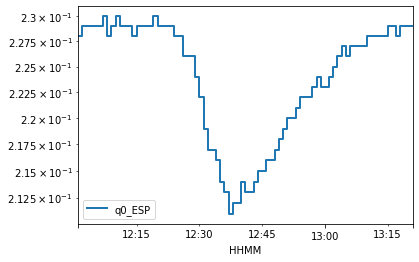

In [95]:
key = EVE_df.keys()[12]
print('GOES = ',event_ref.event_peaktime)
print('Test = ',EVE_df.HHMM[EVE_df[key]==EVE_df[key].max()].values[0])
EVE_df.plot(x='HHMM', y=key, drawstyle="steps", linewidth=2, logy=True)

#### If the really first data in time series is greater than the flux at the peaktime reject. 

#### Plot GOES bringing Data from Sunpy. Apparently XRS-B proxy: a model of the expected XRS-B 0.1-0.8 nm value, calculated using two-component method in the EVE files

#### Read Hugh's paper about EVE during Solar Flares!

Git/GitHub course @ Platzi

In [92]:
from sunpy.net import Fido
from sunpy.net import attrs as a

In [70]:
event_type = "FL"
tstart = "2022/10/1"
tend = "2022/10/15"
result = Fido.search(a.Time(tstart, tend),
                     a.hek.EventType(event_type),
                     a.hek.FL.GOESCls > "C1.0",
                     a.hek.OBS.Observatory == "GOES")

In [71]:
# Here we only show two columns due there being over 100 columns returned normally.
print(result.show("hpc_bbox", "refs"))

# It"s also possible to access the HEK results from the
# `~sunpy.net.fido_factory.UnifiedResponse` by name.

hek_results = result["hek"]

Results from 1 Provider:

122 Results from the HEKClient:

                                                        hpc_bbox                                                        ...
----------------------------------------------------------------------------------------------------------------------- ...
             POLYGON((-1.670367 -950.5608,1.670367 -950.5608,1.67235 951.59484,-1.67235 951.59484,-1.670367 -950.5608)) ...
        POLYGON((-1.670403 -950.58816,1.670403 -950.58816,1.672386 951.62172,-1.672386 951.62172,-1.670403 -950.58816)) ...
        POLYGON((-1.670409 -950.59254,1.670409 -950.59254,1.672391 951.62604,-1.672391 951.62604,-1.670409 -950.59254)) ...
          POLYGON((-1.670419 -950.60028,1.670419 -950.60028,1.672401 951.6336,-1.672401 951.6336,-1.670419 -950.60028)) ...
        POLYGON((-1.670454 -950.62662,1.670454 -950.62662,1.672436 951.65952,-1.672436 951.65952,-1.670454 -950.62662)) ...
          POLYGON((-1.670469 -950.63772,1.670469 -950.63772,1.67245 951.6

In [72]:
print(hek_results.colnames)

['gs_thumburl', 'comment_count', 'hpc_bbox', 'frm_humanflag', 'hgc_coord', 'event_coordsys', 'obs_levelnum', 'hpc_coord', 'event_npixels', 'gs_imageurl', 'ar_polarity', 'frm_paramset', 'hrc_coord', 'event_starttime', 'ar_mtwilsoncls', 'event_type', 'intensmin', 'fl_fluence', 'obs_meanwavel', 'frm_url', 'skel_chaincode', 'bound_chaincode', 'noposition', 'fl_fluenceunit', 'active', 'intensmax', 'frm_versionnumber', 'fl_peaktempunit', 'fl_halphaclass', 'area_uncert', 'obs_dataprepurl', 'hpc_geom', 'hgc_bbox', 'intensmedian', 'chaincodetype', 'obs_channelid', 'event_clippedspatial', 'ar_noaaclass', 'SOL_standard', 'event_avg_rating', 'eventtype', 'intensunit', 'hpc_boundcc', 'event_mapurl', 'frm_contact', 'ar_penumbracls', 'intensmean', 'bound_ccstartc1', 'frm_name', 'area_atdiskcenter', 'frm_identifier', 'obs_observatory', 'event_description', 'boundbox_c2ur', 'obs_firstprocessingdate', 'boundbox_c2ll', 'frm_institute', 'hrc_bbox', 'refs_orig', 'ar_mcintoshcls', 'event_maskurl', 'bound_cc

In [81]:
new_table = hek_results["event_starttime", "event_peaktime",
                        "event_endtime", "fl_goescls", "fl_fluence"]

In [82]:
len(new_table)
#new_table.write("october_M1_flares.csv", format="csv")

122

In [83]:
new_table

event_starttime,event_peaktime,event_endtime,fl_goescls,fl_fluence
Time,Time,Time,str4,object
2022-10-01 02:09:00.000,2022-10-01 02:18:00.000,2022-10-01 02:23:00.000,C2.9,None
2022-10-01 03:55:00.000,2022-10-01 04:01:00.000,2022-10-01 04:07:00.000,C2.6,None
2022-10-01 04:12:00.000,2022-10-01 04:17:00.000,2022-10-01 04:39:00.000,C3.8,None
2022-10-01 04:42:00.000,2022-10-01 04:58:00.000,2022-10-01 05:12:00.000,C6.4,None
2022-10-01 06:24:00.000,2022-10-01 06:30:00.000,2022-10-01 06:34:00.000,C2.3,None
2022-10-01 07:07:00.000,2022-10-01 07:11:00.000,2022-10-01 07:19:00.000,C2.2,None
2022-10-01 08:22:00.000,2022-10-01 08:31:00.000,2022-10-01 08:36:00.000,C3.8,None
2022-10-01 11:34:00.000,2022-10-01 13:00:00.000,2022-10-01 13:22:00.000,C3.5,None
2022-10-01 17:29:00.000,2022-10-01 17:41:00.000,2022-10-01 17:46:00.000,C3.4,None


In [85]:
hek_results

gs_thumburl,comment_count,hpc_bbox,frm_humanflag,hgc_coord,event_coordsys,obs_levelnum,hpc_coord,event_npixels,gs_imageurl,ar_polarity,frm_paramset,hrc_coord,event_starttime,ar_mtwilsoncls,event_type,intensmin,fl_fluence,obs_meanwavel,frm_url,skel_chaincode,bound_chaincode,noposition,fl_fluenceunit,active,intensmax,frm_versionnumber,fl_peaktempunit,fl_halphaclass,area_uncert,obs_dataprepurl,hpc_geom,hgc_bbox,intensmedian,chaincodetype,obs_channelid,event_clippedspatial,ar_noaaclass,SOL_standard,event_avg_rating,eventtype,intensunit,hpc_boundcc,event_mapurl,frm_contact,ar_penumbracls,intensmean,bound_ccstartc1,frm_name,area_atdiskcenter,frm_identifier,obs_observatory,event_description,boundbox_c2ur,obs_firstprocessingdate,boundbox_c2ll,frm_institute,hrc_bbox,refs_orig,ar_mcintoshcls,event_maskurl,bound_ccstartc2,gs_movieurl,event_score,skel_startc2,skel_startc1,fl_efoldtime,event_expires,fl_efoldtimeunit,hrc_boundcc,event_probability,intensvar,frm_daterun,event_coordunit,hpc_y,hpc_x,search_instrument,ar_numspots,kb_archivdate,kb_archivist,intenstotal,sum_overlap_scores,hgs_boundcc,intensskew,obs_includesnrt,rasterscan,obs_wavelunit,kb_archivid,search_frm_name,boundbox_c1ur,ar_noaanum,area_atdiskcenteruncert,boundbox_c1ll,event_importance_num_ratings,ar_compactnesscls,skel_curvature,event_testflag,event_c2error,hrc_r,skel_nsteps,hgs_y,obs_title,fl_peakemunit,hgs_x,hcr_checked,frm_specificid,event_title,obs_instrument,event_c1error,revision,hpc_radius,event_endtime,event_importance,event_coord2,event_coord3,event_coord1,search_observatory,area_raw,concept,event_pixelunit,hgc_boundcc,fl_peakflux,hgc_x,hrc_a,event_peaktime,hgc_y,gs_galleryid,fl_goescls,hgs_coord,ar_zurichcls,bound_ccnsteps,intenskurt,event_clippedtemporal,fl_peakfluxunit,fl_peakem,rasterscantype,search_channelid,fl_peaktemp,hgs_bbox,area_unit,obs_lastprocessingdate,refs
str1,str1,str125,str5,str27,str12,object,str29,object,str1,object,str27,str41,Time,str1,str2,object,object,float64,str25,str1,str1,str5,str1,str4,object,object,str1,str1,object,str1,str186,str93,object,str1,str3,str1,str1,str30,object,str1,str1,str1,str1,str23,str1,object,object,str4,object,str4,str4,str1,float64,str1,float64,str61,str110,str1,str1,str1,object,str1,str20,object,object,object,str1,str1,str1,object,object,str19,str7,float64,float64,str4,object,str19,str19,object,str21,str1,object,str1,str1,str2,str66,str4,float64,int64,object,float64,str1,str1,object,str5,int64,float64,object,int64,str1,str1,int64,str4,str1,str1,str4,int64,str1,str19,Time,object,int64,object,int64,str4,object,str5,str1,str1,object,float64,float64,Time,int64,str1,str4,str13,str1,object,object,str1,str1,object,str1,str3,object,str66,str1,str1,object[1]
,0,"POLYGON((-1.670367 -950.5608,1.670367 -950.5608,1.67235 951.59484,-1.67235 951.59484,-1.670367 -950.5608))",false,POINT(136.66028 0),UTC-HGS-TOPO,None,POINT(0 -112.723626),None,,None,"SSWIDL get_gev, ..., ngdc=0",POINT(0.117705568323869 180),2022-10-01 02:09:00.000,,FL,None,None,5e-08,http://www.swpc.noaa.gov/,,,true,,true,None,None,,,None,,,"POLYGON((46.76028 -89.9,-133.43972 -89.9,-133.43972 89.9,46.76028 89.9,46.76028 -89.9))",None,,XRA,,,SOL2022-10-01T02:09:00L136C090,None,9,,,,SWPC.Webmaster@noaa.gov,,None,None,SWPC,None,SWPC,GOES,,89.9000015258789,,-89.9000015258789,"U.S. Dept. of Commerce, NOAA, Space Weather Prediction Center","POLYGON((0.992573 179.899317,0.992573 180.100683,0.993653 359.899307,0.993653 0.100693,0.992573 179.899317))",,,,None,,0.458000000000000018,None,None,None,,,,None,None,2022-10-01T00:00:00,degrees,-112.723626,0.0,GOES,None,2022-10-02T06:58:10,autosubmission_swpc,None,0,,None,,,cm,ivo://helio-informatics.org/FL_SWPC_20221002_065808_20221001020900,SWPC,89.9000015258789,0,None,-89.9000015258789,,,None,false,90,0.117705568323869,None,0,,,0,true,,,GOES,90,1,112.72362600000001,2022-10-01 02:23:00.000,None,0,None,0,GOES,None,Flare,,,None,136.66028,180.0,2022-10-01 02:18:00.000,0,,C2.9,POINT(0 0),,None,None,,,None,,XRA,None,"POLYGON((-89.9 -89.9

In [84]:
from sunpy.net import Fido
from sunpy.net import attrs as a
from sunpy.timeseries import TimeSeries

In [32]:
a.Instrument.eve?

In [38]:
tstart = "2022-11-18 01:00"
tend = "2022-11-18 23:00"
result = Fido.search(a.Time(tstart, tend), a.Instrument("EVE"))
print(result)

Results from 1 Provider:

1 Results from the EVEClient:
Source: https://lasp.colorado.edu/eve/data_access/evewebdata/quicklook/L0CS/SpWx/

       Start Time               End Time        Instrument ... Source Provider Level
----------------------- ----------------------- ---------- ... ------ -------- -----
2022-11-18 00:00:00.000 2022-11-18 23:59:59.999        EVE ...    SDO     LASP     0




In [39]:
file_eve = Fido.fetch(result)

Files Downloaded:   0%|                                      | 0/1 [00:00<?, ?file/s]
20221118_EVE_L0CS_DIODES_1m.txt:   0%|                    | 0.00/222k [00:00<?, ?B/s]
20221118_EVE_L0CS_DIODES_1m.txt:   0%|           | 1.02k/222k [00:00<01:33, 2.37kB/s]
20221118_EVE_L0CS_DIODES_1m.txt:  44%|█████▎      | 98.7k/222k [00:00<00:00, 219kB/s]
20221118_EVE_L0CS_DIODES_1m.txt:  88%|███████████▍ | 195k/222k [00:00<00:00, 370kB/s]
Files Downloaded: 100%|██████████████████████████████| 1/1 [00:01<00:00,  1.08s/file]


In [44]:
file_eve.data[0]

'/Users/Kamilobu/sunpy/data/20221118_EVE_L0CS_DIODES_1m.txt'

In [22]:
result_goes16 = Fido.search(a.Time(tstart, tend), a.Instrument("EVE"), a.goes.SatelliteNumber(16))
print(result_goes16)

Results from 1 Provider:

1 Results from the XRSClient:
Source: <13: https://umbra.nascom.nasa.gov/goes/fits 
13, 14, 15: https://satdat.ngdc.noaa.gov/sem/goes/data/science/ 
16, 17: https://data.ngdc.noaa.gov/platforms/solar-space-observing-satellites/goes/

       Start Time               End Time        Instrument ... Source Provider
----------------------- ----------------------- ---------- ... ------ --------
2022-06-21 00:00:00.000 2022-06-21 23:59:59.999       GOES ...   GOES     NOAA




In [23]:
file_goes16 = Fido.fetch(result_goes16)

Files Downloaded: 100%|██████████████████████████████| 1/1 [00:00<00:00,  2.10file/s]


In [27]:
file_goes16.data

['/Users/Kamilobu/sunpy/data/sci_xrsf-l2-flx1s_g16_d20220621_v2-1-0.nc']

In [ ]:
a.Instrument.

In [ ]:
wget --recursive \
     --no-clobber \
     --no-parent \
     --accept nc \
     --wait=0.2 \
     --waitretry=10 \
     -e robots=off \
     https://data.ngdc.noaa.gov/platforms/solar-space-observing-satellites/goes/goes16/l2/data/xrsf-l2-avg1m_science/2021/05/


In [ ]:
https://data.ngdc.noaa.gov/platforms/solar-space-observing-satellites/goes/goes16/l1b/exis-l1b-sfeu_science/

In [28]:
import json

In [29]:
# JSON file
f = open ('instrument-sources.json', "r")
  
# Reading from file
data = json.loads(f.read())

In [30]:
data

[{'electrons': {'primary': 16, 'secondary': 17},
  'protons': {'primary': 16, 'secondary': 17},
  'magnetometers': {'primary': 16, 'secondary': 17},
  'xrays': {'primary': 16, 'secondary': 17}}]

## L1b (< 30s) or L2 (~1min average)

In [35]:
from astropy.io import fits as fits
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import matplotlib.dates as md
import numpy as np

In [39]:
path = "./"
eve_filename = 'esp_L1_2022325_007.fit'
hdul = fits.open(path + eve_filename)
ref_time = datetime(year=2022, month=11, day=22, hour=0, minute=0, second=0)
eve_time = [ref_time + timedelta(seconds=i) for i in hdul[1].data['SOD']]

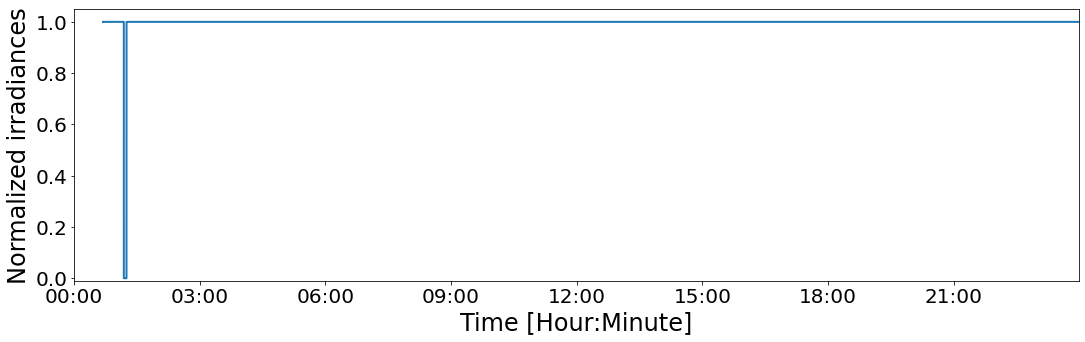

In [40]:
init  = 2300
fig, ax = plt.subplots(figsize=(18,5))
tlim = 10000#180000
plt.step(eve_time[tlim:],
         (hdul[1].data['QD'][tlim:]-hdul[1].data['QD'][tlim:].min())/(hdul[1].data['QD'][tlim:]-hdul[1].data['QD'][tlim:].min()).max(),
         linewidth=2,label='SDO EVE 0.1 -- 7.0 nm')

# # EVE 30 nm
# tlim = 285000
# plt.step(eve_time[tlim:],
#          (hdul[1].data['CH_30'][tlim:]-hdul[1].data['CH_30'][tlim:].min())/(hdul[1].data['CH_30'][tlim:]-hdul[1].data['CH_30'][tlim:].min()).max(),
#          linewidth=2,label='SDO EVE 30 nm',alpha=.7)

# ornaments
ax.set_xlim([datetime(2022,11,22,0,0), datetime(2022,11,22,23,59)])
ax.set_ylim([-0.01,1.05])
xfmt = md.DateFormatter('%H:%M')
ax.xaxis.set_major_formatter(xfmt)
ax.set_xlabel('Time [Hour:Minute]',fontsize=24)
ax.set_ylabel('Normalized irradiances',fontsize=24)
ax.tick_params(axis='both', labelsize=20)

In [29]:
hdul[1].data['QD']

FITS_rec([(0.00025504, 0.00025504, 0.00025504, 0.00025504, 0.00025617, 0.00084413, 0.00044788, 0.00083562, -1.7472479e-06, 49., 1.2876567e-06, 1.2876567e-06, 1.2876567e-06, 1.2876567e-06, 2.5753134e-06, 7.845548e-07, 1.6131069e-06, 1.3165507e-06, 4.0628397e-06, 0.45645425, 2., 21.25, 2022, 325, 1.09449148e-01, 1325.5636, 962.07983, 3174.1765, 1353.1543, 0, 0),
          (0.00025353, 0.00025353, 0.00025353, 0.00025353, 0.00025465, 0.00084462, 0.00045961, 0.00083542, -1.7560504e-06, 48., 1.2876567e-06, 1.2876567e-06, 1.2876567e-06, 1.2876567e-06, 2.5753134e-06, 7.845548e-07, 1.6131069e-06, 1.3165507e-06, 4.0628397e-06, 0.45645425, 2., 21.25, 2022, 325, 3.59449148e-01, 1317.7272, 978.8541 , 3168.1143, 1353.1543, 0, 0),
          (0.00025428, 0.00025428, 0.00025428, 0.00025428, 0.00025541, 0.00084786, 0.00045568, 0.00083542, -1.7560504e-06, 47., 1.2876567e-06, 1.2876567e-06, 1.2876567e-06, 1.2876567e-06, 2.5753134e-06, 7.845548e-07, 1.6131069e-06, 1.3165507e-06, 4.0628397e-06, 0.45645425, 

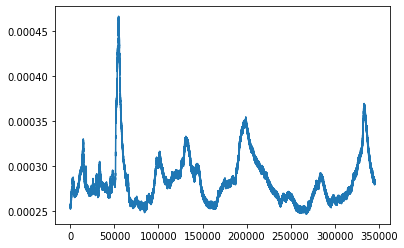

In [42]:
plt.plot(hdul[1].data['QD'])

In [45]:
len(hdul[1].data['QD'])

345600

In [41]:
hdul[1].data['QD'][hdul[1].data['QD'] == -1] = 0.0003

In [44]:
len(eve_time)

345600